## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np

import os

In [2]:
print(tf.config.list_physical_devices('GPU'))  

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

batch_size = 32
epochs = 25

## Get data

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In TensorFlow this can be done via the `tf.keras.preprocessing.image.ImageDataGenerator` class. This class allows you to:

- configure random transformations and normalization operations to be done on your image data during training
- instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the `tf.keras` model methods that accept data generators as inputs, `fit`, `evaluate` and `predict`.

In [4]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"valid")

# Identify Plant Diseases

We use the PlantVillage dataset [1] by Hughes et al. consists of about 87,000 healthy and unhealthy leaf images divided into 38 categories by species and disease. Here we provide a subset of our experiments on working with this data. We also end up transfer learning from MobileNet and use the weights from pre-training on ImageNet.

* ![PlantVillage Dataset Samples](https://i.imgur.com/Zcxdrlc.png)
Figure 1. PlantVillage Dataset Samples

## Classes

The following 38 classes are availaible in the dataset

- `Apple___Apple_scab` 
- `Apple___Black_rot` 
- `Apple___Cedar_apple_rust` 
- `Apple___healthy` 
- `Blueberry___healthy` 
- `Cherry_(including_sour)___Powdery_mildew` 
- `Cherry_(including_sour)___healthy` 
- `Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot` 
- `Corn_(maize)___Common_rust_` 
- `Corn_(maize)___Northern_Leaf_Blight` 
- `Corn_(maize)___healthy', 'Grape___Black_rot` 
- `Grape___Leaf_blight_(Isariopsis_Leaf_Spot)` 
- `Grape___healthy` 
- `Orange___Haunglongbing_(Citrus_greening)` 
- `Peach___Bacterial_spot` 
- `Peach___healthy` 
- `Pepper,_bell___Bacterial_spot` 
- `Pepper,_bell___healthy` 
- `Potato___Early_blight` 
- `Potato___Late_blight` 
- `Potato___healthy` 
- `Raspberry___healthy` 
- `Soybean___healthy` 
- `Squash___Powdery_mildew` 
- `Strawberry___Leaf_scorch` 
- `Strawberry___healthy` 
- `Tomato___Bacterial_spot` 
- `Tomato___Late_blight` 
- `Tomato___Leaf_Mold` 
- `Tomato___Septoria_leaf_spot` 
- `Tomato___Spider_mites Two-spotted_spider_mite` 
- `Tomato___Target_Spot` 
- `Tomato___Tomato_Yellow_Leaf_Curl_Virus` 
- `Tomato___Tomato_mosaic_virus` 
- `Tomato___healthy`

## References

[1] Hughes, David P., and Marcel Salathe. “An Open Access Repository of Images on Plant Health to Enable the Development of Mobile Disease Diagnostics.” ArXiv:1511.08060 [Cs], Apr. 2016. arXiv.org, http://arxiv.org/abs/1511.08060.

[2] Howard, Andrew G., et al. “MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications.” ArXiv:1704.04861 [Cs], Apr. 2017. arXiv.org, http://arxiv.org/abs/1704.04861.


In [ ]:
def show_images_from_each_class(data_dir, num_classes, images_per_class=1):
    """
    Displays a grid of images, showing one sample from each class.
    It reads directly from the directories to guarantee that each class is shown.

    Args:
        data_dir: The path to the directory containing the class subdirectories.
        num_classes: The number of classes in the dataset.
        images_per_class: How many images to display from each class.
    """
    plt.figure(figsize=(20, 20))
    cols = 5
    rows = (num_classes + cols - 1) // cols

    class_names = sorted(os.listdir(data_dir))  # Get sorted list of class names (directories)
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_dir)
        if len(image_files) > 0:
             # Load the first image.
            img_path = os.path.join(class_dir, image_files[0])
            img = image.load_img(img_path, target_size=(224, 224))  # Or your target size
            img_array = image.img_to_array(img) / 255.0 #normalize

            plt.subplot(rows, cols, class_index + 1)
            plt.imshow(img_array)
            plt.title(class_name, fontsize=12)
            plt.axis('off')
        else:
            plt.subplot(rows, cols, class_index + 1)
            plt.text(0.5, 0.5, f"No images in {class_name}", ha='center', va='center', color='red')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot all of the classes of lleafes
show_images_from_each_class(train_dir, num_classes=38, images_per_class=1)

We make the following augmentations to the images:

- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- `rescale` is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- `shear_range` is for randomly applying shearing transformations
- `zoom_range` is for randomly zooming inside pictures
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [5]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             fill_mode="nearest")

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

Let's prepare our data. We will use `.flow_from_directory()` to generate batches of image data (and their labels) directly from our images in their respective folders.

In [6]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (image_size, image_size),
                                               batch_size = batch_size,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             class_mode = "categorical")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


## Create a classes index file

We also want to know which class corresponds to which species and disease so we also create a `json` file which shows corresponding labels and class indices.

In [7]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [8]:
import json
with open('class_indices.json','w') as f:
  json.dump(train_data.class_indices, f)

from IPython.display import FileLink
FileLink(r'class_indices.json')

/kaggle/working/class_indices.json

## Training

We first get the base MobileNet model without including the top layers since we want to use it for 38 classes and us the pre-trained weights for ImageNet.

In [9]:
base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

base_model.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


We now create a small upstream model on top of the MobileNet using the functional API

In [10]:
#define the input shape of the data the model expects
inputs = keras.Input(shape = input_shape)
#we then pass the input data through a pretrained base model whihc processes th image
x = base_model(inputs, training = False)
#GAP reduces the spatial dimenstion of the each feature map - 2D to Single value
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#drop out layer that randomly disables 20% of the neruons
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(len(categories), 
                          activation="softmax")(x)

model = keras.Model(inputs = inputs, outputs = x, name="LeafDisease_MobileNet")

In our multiple experiments we found out Adam optimizer to work really well with it's default learning rate, $\beta_1$, $\beta_2$ and $\epsilon$ values

In [11]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(), 
                       'accuracy'])

In [12]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=10,
                    steps_per_epoch=150,
                    validation_steps=100)

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5535: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "categorical_crossentropy"


150/150 [==============================] - 117s 737ms/step - loss: 2.0762 - categorical_accuracy: 0.4575 - accuracy: 0.4575 - val_loss: 0.8461 - val_categorical_accuracy: 0.7847 - val_accuracy: 0.7847
Epoch 2/10
150/150 [==============================] - 122s 815ms/step - loss: 0.8098 - categorical_accuracy: 0.7763 - accuracy: 0.7763 - val_loss: 0.4937 - val_categorical_accuracy: 0.8675 - val_accuracy: 0.8675
Epoch 3/10
150/150 [==============================] - 105s 702ms/step - loss: 0.5649 - categorical_accuracy: 0.8290 - accuracy: 0.8290 - val_loss: 0.4122 - val_categorical_accuracy: 0.8822 - val_accuracy: 0.8822
Epoch 4/10
150/150 [==============================] - 103s 690ms/step - loss: 0.4611 - categorical_accuracy: 0.8631 - accuracy: 0.8631 - val_loss: 0.3557 - val_categorical_accuracy: 0.8928 - val_accuracy: 0.8928
Epoch 5/10
150/150 [==============================] - 149s 999ms/step - loss: 0.3908 - categorical_accuracy: 0.8867 - accuracy: 0.8867 - val_loss: 0.2906 - val_cat

## Review the training process

In [15]:
# Recreate test_data with a reasonable batch size and no shuffling
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
test_data_2 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),  # Likely (224, 224) for MobileNet
    batch_size=64,  # Larger batch size for efficiency
    class_mode="categorical",
    shuffle=False  # Ensure consistent label order
)

# Verify test_data configuration
print(f"Test samples: {test_data_2.samples}, Batch size: {test_data_2.batch_size}")

Found 17572 images belonging to 38 classes.
Test samples: 17572, Batch size: 64


In [40]:
import itertools
import time
# Define sample size
sample_size = 5000
max_batches = (sample_size // test_data_2.batch_size) + (1 if sample_size % test_data_2.batch_size else 0)
print(f"Using {sample_size} images, {max_batches} batches")

# Collect labels and predictions
labels = []
predictions = []
start_time = time.time()
test_data_2.reset()
for i, (x, y) in enumerate(test_data_2):
    if i >= max_batches:
        break
    print(f"Batch {i+1}: x shape: {x.shape}, y shape: {y.shape}")
    labels.append(y)
    pred = model.predict(x, verbose=1)
    pred_indices = tf.argmax(pred, 1).numpy()
    print(f"Prediction shape: {pred.shape}, Argmax shape: {pred_indices.shape}")
    predictions.append(pred_indices)
    print(f"Processed batch {i + 1}/{max_batches}, time elapsed: {time.time() - start_time:.2f} seconds")

Using 5000 images, 79 batches
Batch 1: x shape: (64, 224, 224, 3), y shape: (64, 38)
Prediction shape: (64, 38), Argmax shape: (64,)
Processed batch 1/79, time elapsed: 0.42 seconds
Batch 2: x shape: (64, 224, 224, 3), y shape: (64, 38)
Prediction shape: (64, 38), Argmax shape: (64,)
Processed batch 2/79, time elapsed: 0.83 seconds
Batch 3: x shape: (64, 224, 224, 3), y shape: (64, 38)
Prediction shape: (64, 38), Argmax shape: (64,)
Processed batch 3/79, time elapsed: 1.24 seconds
Batch 4: x shape: (64, 224, 224, 3), y shape: (64, 38)
Prediction shape: (64, 38), Argmax shape: (64,)
Processed batch 4/79, time elapsed: 1.66 seconds
Batch 5: x shape: (64, 224, 224, 3), y shape: (64, 38)
Prediction shape: (64, 38), Argmax shape: (64,)
Processed batch 5/79, time elapsed: 2.08 seconds
Batch 6: x shape: (64, 224, 224, 3), y shape: (64, 38)
Prediction shape: (64, 38), Argmax shape: (64,)
Processed batch 6/79, time elapsed: 2.53 seconds
Batch 7: x shape: (64, 224, 224, 3), y shape: (64, 38)
Pre

In [43]:
predictions = np.concatenate(predictions).tolist()
labels = [np.argmax(y, axis=1) for y in labels]
labels = list(itertools.chain.from_iterable(labels))

# Trim to exact sample size
labels = labels[:sample_size]
predictions = predictions[:sample_size]

# Generate confusion matrix
unique_labels = sorted(set(labels))
cm = confusion_matrix(labels, predictions, labels=unique_labels)


Confusion Matrix:
[[486   5   0   6   0   1   0   0   0   0   0]
 [  7 483   0   2   0   0   4   0   0   0   0]
 [ 17   0 414   1   1   1   0   0   0   0   0]
 [  8   3   0 480   0   0   3   0   0   0   0]
 [  3   0   1   0 442   0   0   0   0   0   0]
 [  2   1   0   0   0 417   0   0   0   0   0]
 [  0   0   0   0   0   0 455   0   0   0   0]
 [  1   0   0   0   0   0   0 366   1  42   0]
 [  0   0   0   0   0   0   0   0 476   1   0]
 [  0   0   0   0   0   0   0  26   2 443   1]
 [  0   0   0   0   0   0   0   0   3   0 359]]


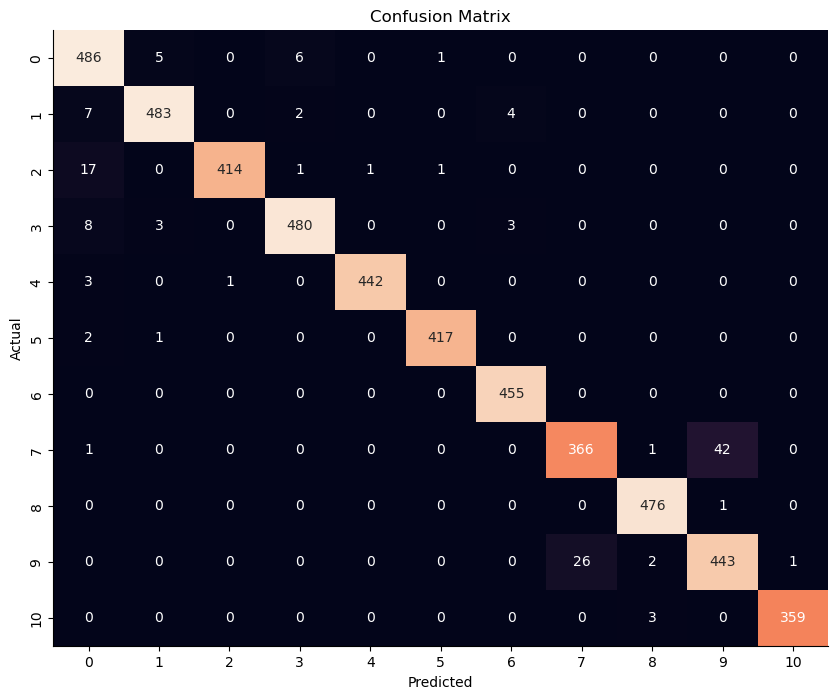

In [47]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
sns.despine()
plt.show()

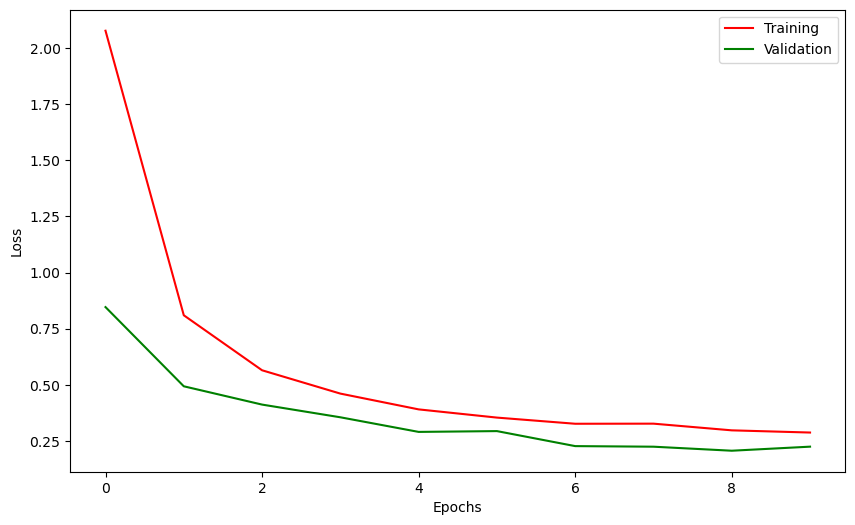

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="green",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

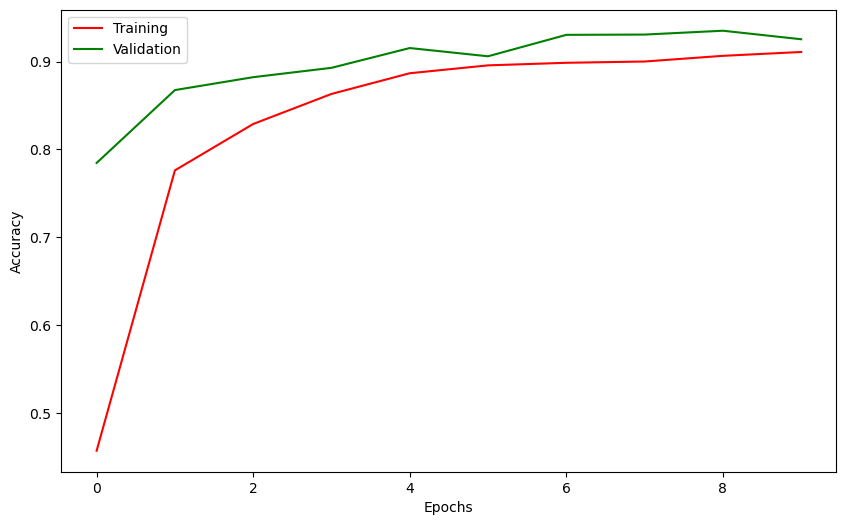

In [28]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="green",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## **Testing**

In [32]:
image_paths = [
    "/kaggle/input/new-plant-diseases-dataset/test/test/AppleCedarRust1.JPG",
    "/kaggle/input/new-plant-diseases-dataset/test/test/CornCommonRust1.JPG",
    "/kaggle/input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight1.JPG",
    "/kaggle/input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight6.JPG"
    ]

In [34]:
# Try to get class names from test_data_2 if it exists
if 'test_data_2' in globals():
    class_names = [None] * len(test_data_2.class_indices)
    for name, index in test_data_2.class_indices.items():
        class_names[index] = name
else:
    # If test_data_2 is not available, define class_names manually
    class_names = [
        "Apple___Cedar_apple_rust",
        "Corn___Common_rust",
        "Tomato___Early_blight",
        # Add all other class names here in the correct order (total should match your model’s output size)
    ]
    print("Warning: test_data_2 not found. Manually defined class_names; ensure they match your model’s training classes.")

print("Available class names:", class_names)

Available class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mit

In [36]:
# Your image paths
image_paths = [
    "/kaggle/input/new-plant-diseases-dataset/test/test/AppleCedarRust1.JPG",
    "/kaggle/input/new-plant-diseases-dataset/test/test/CornCommonRust1.JPG",
    "/kaggle/input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight1.JPG",
    "/kaggle/input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight6.JPG"
]

# Define true classes for these images (must match class_names exactly)
true_classes = [
    "Apple___Cedar_apple_rust",  # From AppleCedarRust1.JPG
    "Corn_(maize)___Common_rust_",        # From CornCommonRust1.JPG
    "Tomato___Early_blight",     # From TomatoEarlyBlight1.JPG
    "Tomato___Early_blight"      # From TomatoEarlyBlight6.JPG
]

# Verify that true_classes match class_names
for true_class in true_classes:
    if true_class not in class_names:
        print(f"Warning: '{true_class}' not in class_names. Check spelling, case, or class_names definition.")

1/1 [==============================] - 0s 21ms/step


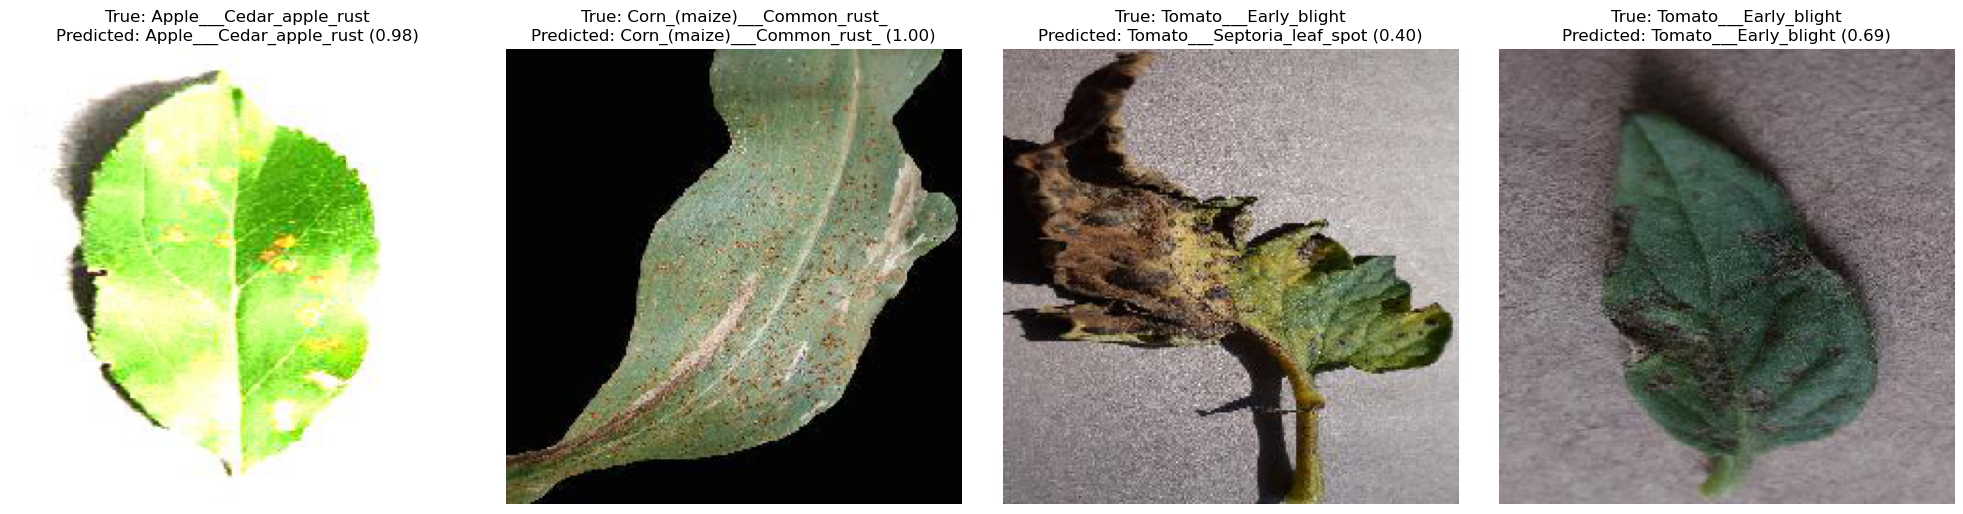

In [37]:
# Number of images to display
num_images = len(image_paths)

# Create a grid for display (1 row, num_images columns)
fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
if num_images == 1:
    axes = [axes]  # Ensure axes is iterable for a single image

# Process each image
for ax, img_path, true_class in zip(axes, image_paths, true_classes):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust size if your model uses a different input shape
    img_array = image.img_to_array(img) / 255.0             # Rescale to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)           # Add batch dimension

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]      # Get the predicted class index
    confidence = np.max(prediction)                         # Get the confidence score
    predicted_name = class_names[predicted_class]           # Map index to class name

    # Display the image with labels
    ax.imshow(img)
    ax.set_title(f'True: {true_class}\nPredicted: {predicted_name} ({confidence:.2f})')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Save the model
We finally save the model in the standard TensorFlow 2 SavedModel format.

In [38]:
model.save('disease_detector.h5')